<a href="https://colab.research.google.com/github/andresenrique08/ML_2020/blob/master/Proyecto_Malware/Malware_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Malware

**Curso de Machine Learning 2020-20**

*Proyecto Final*

Autores:


*   Andrés Enrique Ávila Rojas (201319127)
*   Jeison Alexander Timana Rangel (201617870)

Descripción de lo que se hace en el notebook...



In [1]:
# Importing libraries
import numpy as np
import pydrive as drive
from google.colab import drive
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)

Se dan los permisos para acceder al almecenamiento de drive.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Preparación de los datos

En esta sección se presenta la lectura y análisis preliminar de los datos de entrenamiento y los datos de validación. Estos datos vienen en dos archivos de formato csv separado por comas y pueden ser obtenidos de la página de la  <a href="https://www.kaggle.com/c/microsoft-malware-prediction/data">competencia de microsoft para la dección de malware</a> disponible en kaggle. El peso de los conjuntos de datos es:


*   train.csv: 4.08 GB
*   test.csv: 3.53 GB



**Datos de entrenamiento**

In [3]:
%%time
ruta_train = '/content/drive/MyDrive/Machine Learning/train.csv'
train  = pd.read_csv(ruta_train) 

<string>:2: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 17s, sys: 10.7 s, total: 1min 27s
Wall time: 1min 36s


In [4]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,...,HDD,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,...,HDD,102385.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4909.0,317701.0,4.0,5.0,...,SSD,113907.0,0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,88,20710.0,NaN,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,...,UNKNOWN,227116.0,0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,355.0,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417e

In [5]:
train.shape

(8921483, 83)

Se observan los valores únicos de la variable de salida.

In [6]:
train.HasDetections.unique()

array([0, 1])

La variable objetivo ```HasDectections``` sólo tiene dos valores. Donde 1 indica que se ha detectado un Malware y 0 indica que no se detectó Malware.

In [ ]:
fig = plt.figure()
train['HasDetections'].plot.bar()
plt.grid(linestyle='--',b=True, which='major')
plt.ylabel('Frecuencia absoluta')
plt.title('Histograma de detection en conjunto train', fontsize=14)
plt.show()

**Datos de validación**

In [ ]:
%%time
ruta_test = '/content/drive/MyDrive/Machine Learning/test.csv'
test  = pd.read_csv(ruta_test) 

<string>:2: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 21s, sys: 16.3 s, total: 1min 37s
Wall time: 1min 46s


In [ ]:
test.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0000010489e3af074adeac69c53e555e,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,58552.0,18.0,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2689.0,30661.0,4.0,5.0,...,488386.0,SSD,123179.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,807.0,8554.0,1,NaN,0.0,0,0,0.0,0.0,7.0
1,00000176ac758d54827acd545b6315a5,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,68,71395.0,NaN,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,...,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,554.0,33105.0,1,NaN,0.0,0,0,0.0,1.0,12.0
2,0000019dcefc128c2d4387c1273dae1d,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,NaN,49480.0,2.0,1.0,1,201,66202.0,NaN,267.0,251,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,NaN,NaN,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,...,29820.0,SSD,28678.0,0,4096.0,Notebook,13.9,1280.0,720.0,Mobile,NaN,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,556.0,63396.0,1,NaN,0.0,0,0,0.0,1.0,11.0
3,0000055553dc51b1295785415f1a224d,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,NaN,42160.0,2.0,1.0,1,29,120917.0,NaN,35.0,171,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,...,476940.0,HDD,439345.0,0,4096.0,Notebook,14.0,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.371,amd64,rs3_release,16299,371,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,26.0,119,Notify,0,IS_GENUINE,OEM:D

In [ ]:
test.shape

(7853253, 82)

Preliminarmente se puede analizar que los conjuntos de datos de entrenamiento y de validación no tienen la misma cantidad de variables (Como se observa en la siguiente tabla). En este caso es fácil identificar que en los datos de validación no cuentan con la variable objetivo ```HasDetections``` por lo que no sería muy útil usarlos en la validación y evaluación del modelo propuesto.

Dataframe | No. de datos | No. de Variables |
----------|--------------|------------------|
Train | 8.921.483 | 83 |
Test | 7.853.253 | 82 |

Sin embargo, se indagó en la página de la <a href="https://www.kaggle.com/c/microsoft-malware-prediction/data">competencia de microsoft para la dección de malware</a> y se encontró otra base de datos disponibles, parece ser la columna de detección de malware con la variable que hace falta en el conjunto test, sin embargo como se observa en la siguiente figura, esta columna solo tiene valores iguales a 0.5, y corresponden a los valores que deben ser actualizados por los participantes de la competencia.

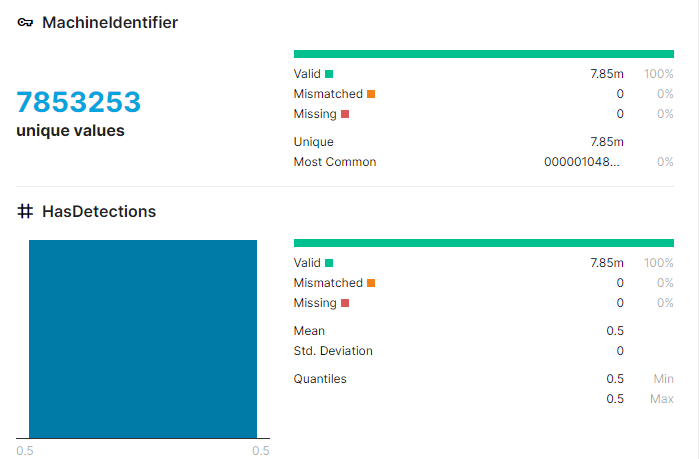


Debido a esto, sólo se usará el dataframe de train, la cual se dividirá para obtener los datos de validación y de entrenamiento, mediante la función ```train_test_split``` de scikit-learn. Mientras que el dataframe de test cargado en este notebook se eliminará.

In [ ]:
del test

## Etapa de preprocesamiento de los datos

En esta sección se busca realizar las modificaciones y la limpieza necesaria de los datos para la inclusión en los modelos a probar y desarrollar posteriormente. Algunos de los puntos principales que se realizan en esta etapa son:


*   Revisar si hay filas de datos duplicadas o redundantes que puedan considerarse obsoletas en el modelo.
*   Analizar los datos nulos o perdidos dentro de la base de datos, y tomar decisiones respecto al manejo que se les darán.
*   Analizar la existencia de datos atípicos por cada una de las columnas de datos disponibles para los análisis. 
*   Revisar la oblicuidad de la distribución de los datos, analizando el porcentaje más alto que puede tener una característica o valor único dentro de cada variable.
*   Hacer las transformaciones necesarias de los datos para que puedan ser utilizados dentro de los modelos. 



Inicialmente se verifica la existencia de filas duplicadas.

In [7]:
train.duplicated().sum()

0

Se observa que dentro de la data disponible no existen datos repetidos. 

A continuación se presenta una tabla con información relevante para el análisis y limpieza de datos. En esta se presenta el porcentaje de datos nulos para cada variable, el porcentaje de ceros que existen, el tipo de datos, el número de valores únicos de cada variable, y la categoria de la variable con el mayor porcentaje de datos repetidos (buscando un análisis de la distribución estadística de los datos)

In [11]:
def mytable(data):
    stats = []
    for col in data.columns:
        stats.append((col, data[col].isnull().sum()/data.shape[0]*100, (data[col]==0).sum()/data.shape[0]*100, 
                      data[col].dtype,data[col].nunique(),data[col].value_counts(normalize=True, dropna=False).values[0] * 100))
        
    mis_val_table = pd.DataFrame(stats, columns=['Variable','% de datos nulos','% de ceros','Tipo de datos','# de valores diferentes','% de la categoria con más datos'])
    return mis_val_table

In [12]:
stats_train = mytable(train)
stats_train = stats_train.sort_values(by=['% de datos nulos'], ascending = False)
stats_train

,Variable,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de la categoria con más datos
28,PuaMode,99.974119,0.000000,object,2,99.974119
41,Census_ProcessorClass,99.589407,0.000000,object,3,99.589407
8,DefaultBrowsersIdentifier,95.141637,0.000000,float64,2017,95.141637
68,Census_IsFlightingInternal,83.044030,16.955735,float64,2,83.044030
52,Census_InternalBatteryType,71.046809,0.000000,object,78,71.046809
71,Census_ThresholdOptIn,63.524472,36.466381,float64,2,63.524472
75,Census_IsWIMBootEnabled,63.439038,36.560951,float64,2,63.439038
31,SmartScreen,35.610795,0.000000,object,21,48.379658
15,OrganizationIdentifier,30.841487,0.000000,float64,49,47.037662
29,SMode,6.027686,93.928812,float64,2,93.928812


Teniendo en cuenta la organización dada a la tabla, donde se organiza de mayor porcentaje de datos perdidos al menor, se puede analizar lo siguiente: 

*  Las variable ```PuaMode```, ```Census_ProcessorClass``` y ```DefaultBrowsersIdentifier``` tiene un porcentaje de datos perdidos superior al 90%.
*  Algunas variables tienen entre sus datos no nulos altos porcentajes de ceros. En algunos casos se tiene que la suma del porcentaje de datos nulos y de datos iguales es mayor al 99%, lo que nos podría decir que estas variables pueden ser ignoradas del análisis puesto que no brindan mucha información. Estás variables son: ```Census_ThresholdOptIn```, ```Census_IsWIMBootEnabled```, ```SMode```, ```Census_IsFlightingInternal```, ```Census_IsFlightsDisabled```, ```Census_IsVirtualDevice```, ```Census_IsPortableOperatingSystem```, ```IsBeta```, ```IsSxsPassiveMode```,```AutoSampleOptIn```.
* Teniendo en cuenta que no es posible completar la información de los datos perdidos, con el fin de no perder un alto porcentaje de datos, se decide eliminar las variables con un porcentaje de datos perdidos superior al 30%, en este caso son: ```Census_InternalBatteryType```, ```SmartScreen```, ```OrganizationIdentifier```.

De esta manera se propone realizar la eliminación de estas variables. Justificando que no aportan información relevante para el modelo.

In [22]:
A_eliminar1 = ['PuaMode','Census_ProcessorClass','DefaultBrowsersIdentifier','Census_ThresholdOptIn','Census_IsWIMBootEnabled','SMode','Census_IsFlightingInternal'
        ,'Census_IsFlightsDisabled','Census_IsVirtualDevice','Census_IsPortableOperatingSystem','IsBeta','IsSxsPassiveMode','AutoSampleOptIn'
        ,'Census_InternalBatteryType','SmartScreen','OrganizationIdentifier']
for rem in A_eliminar1:
  train = train.drop(rem, axis=1)

In [28]:
train = train.drop(['Census_IsFlightingInternal'], axis=1)

Una vez eliminadas estas columnas se verifica el nuevo tamaño del data frame, observando que ahora quedan 70 variables para nuestro análisis. 

In [29]:
train.shape

(8921483, 70)

Con esto en mente, se procede a eliminar las filas que contengan datos nulos.

In [ ]:
train = train.dropna()

Obteniendo así TANTOS datos.

In [ ]:
train.shape

A continuación se verificará nuevamente la calidad de los datos con la tabla presentada anteriormente, en esta oportunidad se organizará por aquellas que tengan un alto porcentaje de desbalance en sus características, comparando así la oblicuidad de la distribución de los datos de cada variable.

In [30]:
stats_train = mytable(train)
stats_train = stats_train.sort_values(by=['% de la categoria con más datos'], ascending = False)
stats_train

,Variable,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de la categoria con más datos
29,Census_DeviceFamily,0.000000,0.000000,object,3,99.838256
27,UacLuaenable,0.121482,0.603610,float64,11,99.271803
1,ProductName,0.000000,0.000000,object,6,98.935569
9,HasTpm,0.000000,1.202894,int64,2,98.797106
8,AVProductsEnabled,0.405998,0.290961,float64,6,97.002942
5,RtpStateBitfield,0.362249,2.137548,float64,7,96.973642
26,Firewall,1.023933,2.119816,float64,2,96.856251
17,OsVer,0.000000,0.000000,object,58,96.761323
15,Platform,0.000000,0.000000,object,4,96.606304
65,Census_IsPenCapable,0.000000,96.192909,int64,2,96.192909


Analizando la tabla se observa que 16 variables tienen una de sus categorias de valores únicos más del 90% de los datos. Este alto desbalance en los datos puede ocasionar que el modelo de clasificación usado para este problema tome las características de menor presencia en las variables como ruido para el modelo, por lo que se podría presentar errores en la clasificación de las características de menos presencia con respecto a las que tienen mayor porcentaje de aparición. 

## Análisis Exploratorio de los Datos (EDA)